In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Helper Functions

In [2]:
from sklearn.metrics import make_scorer
from sklearn.metrics import root_mean_squared_error 
from sklearn.metrics import mean_absolute_error
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

from sklearn import neighbors

In [3]:
def plot_monthly_rmse(y_test, y_pred, title=None):
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    monthly_rmse = pd.Series()
    for month in range(12):
        test_month = results[results.index.month == (month+1)]
        monthly_rmse.loc[month+1] = root_mean_squared_error(test_month['Measured'],test_month['Predicted'])
    sns.barplot(monthly_rmse)
    plt.title(f"{title} Root Mean Squared Error")

In [4]:
def plot_monthly_mae(y_test, y_pred, title=None, export=None):
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    monthly_mae = pd.Series()
    for month in range(12):
        test_month = results[results.index.month == (month+1)]
        monthly_mae.loc[month+1] = mean_absolute_error(test_month['Measured'],test_month['Predicted'])
    sns.barplot(monthly_mae)
    if title:
        plt.title(f"{title} Mean Absolute Error")
    plt.ylabel("Mean Absolute Error (kWh)", fontsize=14)
    plt.xlabel(f"Month", fontsize=14)
    plt.tight_layout()
    if export:
        plt.savefig(f"../figures/{export}.pdf")

In [5]:
def summary(y_test, y_pred, title=None, export=None):
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f} kWh")
    print(f"RMSE: {root_mean_squared_error(y_test,y_pred):.4f} kWh")
    results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})
    plt.figure(figsize=(8,8))
    ax = sns.scatterplot(results, x="Measured", y="Predicted")
    plt.plot([0, results.max().min()], [0,results.max().min()], linewidth=2, color='r')
    # plt.title(title)
    # plt.figure(figsize=(16,8))
    # plot_monthly_rmse(y_test, y_pred, title=title)
    # plt.title(title)
    plt.figure(figsize=(8,4))
    plot_monthly_mae(y_test, y_pred, title=title, export=export)

In [6]:
def monthly_train_and_predict(df, method, params, target_var='2018 Actual Meteorological Year Generation (kWh)', title=None, export=None):
    results = pd.DataFrame()
    monthly_rmse = pd.Series()
    monthly_mae = pd.Series()
    for month in range(1,13):
        # Split test and training set (target month is the test set)
        train = df[df.month != month]
        test = df[df.month == month]

        x_train = train.drop([target_var, 'month'], axis=1)
        y_train = train[target_var]

        x_test = test.drop([target_var, 'month'], axis = 1)
        y_test = test[target_var]

        # Create the model with the passed method
        model = method(**params)
        # Train the model
        model.fit(x_train, y_train)

        # Generate the predictions
        y_pred = model.predict(x_test)

        # Set minimum value
        y_pred[y_pred < y_train.min()] = y_train.min()

        # Create a DF with both predictions and measure data
        month_results = pd.DataFrame({"Measured": y_test, "Predicted": pd.Series(y_pred, index=y_test.index)})

        # Get the RMSE for just this month
        monthly_rmse.loc[month] = root_mean_squared_error(month_results['Measured'],month_results['Predicted'])
        monthly_mae.loc[month] = root_mean_squared_error(month_results['Measured'],month_results['Predicted'])

        results = pd.concat([results, month_results])

    summary(results['Measured'], results['Predicted'], title=title, export=export)
    return results

In [7]:
weather = pd.read_csv("../Project_data/Normalized Data/noaa_sunnyvale_weather_hourly_2018.csv", index_col=0, parse_dates=True)
generation = pd.read_csv("../Project_data/Normalized Data/sunnyvale_generation_hourly_2018.csv", index_col=0, parse_dates=True)

In [8]:
# Merge datasets together
og_df = pd.merge(weather.shift(-1), generation, left_index=True, right_index=True)
df = og_df.copy()

In [9]:
# Fill all cloudCover missing values with the previous value
df['cloudCover'] = og_df['cloudCover'].ffill()

In [10]:
# Add Date Information
df['month'] =                   pd.to_numeric(og_df.index.strftime('%-m'))
df['month_from_equinox'] =      abs(7 - pd.to_numeric(og_df.index.strftime('%-m')))
df['day'] =                     pd.to_numeric(og_df.index.strftime("%-d"))
df['day_of_week'] =             pd.to_numeric(og_df.index.strftime("%w"))
df['day_of_year'] =             og_df.index.dayofyear
df['hour'] =                    pd.to_numeric(og_df.index.strftime("%-H"))

In [11]:
# Add time from noon
df['hours_from_noon'] = abs(df['hour'] - 12)

In [12]:
# Trim last entry
df = df.iloc[24*7:-1]

In [13]:
# Output Generation Predictor File
df.to_csv("../Project_data/Predictor Data/generation.csv")

In [14]:
train = df.copy()
test = df.copy()

x_train = train.drop('2018 Actual Meteorological Year Generation (kWh)', axis=1)
y_train = train['2018 Actual Meteorological Year Generation (kWh)']

x_test = test.drop('2018 Actual Meteorological Year Generation (kWh)', axis = 1)
y_test = test['2018 Actual Meteorological Year Generation (kWh)']

# Linear Regression

MAE: 0.619 kWh
RMSE: 1.1663 kWh


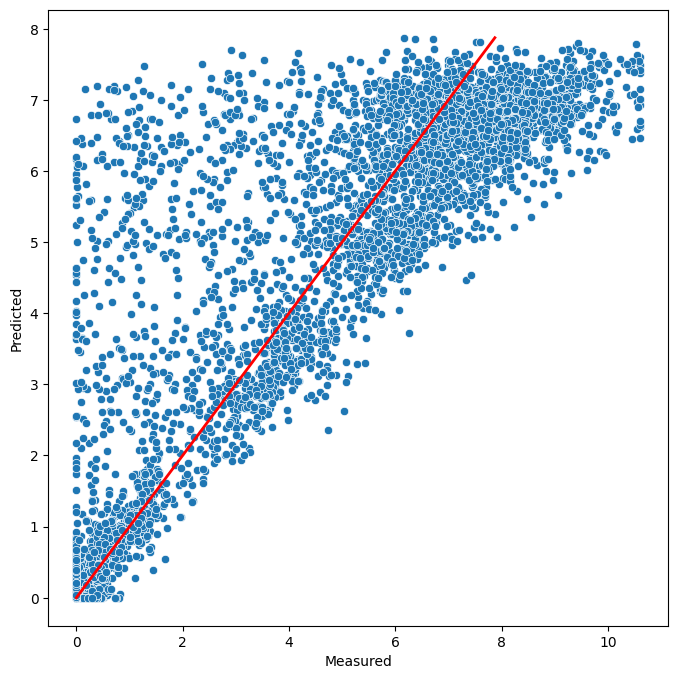

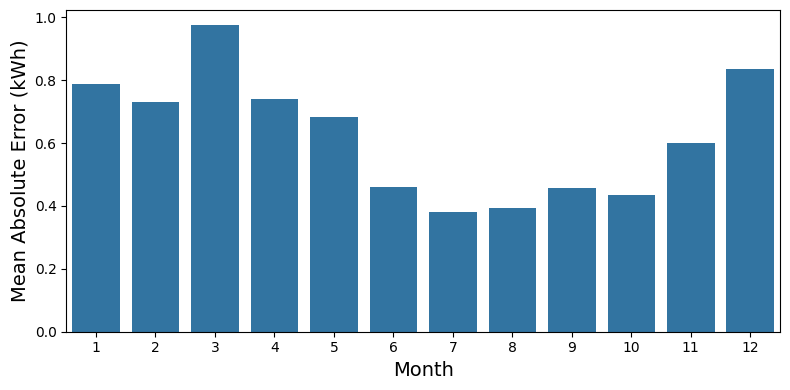

In [15]:

from sklearn.linear_model import LinearRegression

mlr_results = monthly_train_and_predict(df, LinearRegression, {"n_jobs":-1}, export="Generation Linear Regression Monthly MAE")


# K Nearest Neighbors

In [16]:
# Hyperparameter Tuning
params = {'n_neighbors':range(2,30)}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5, scoring=mae_scorer)
model.fit(x_train,y_train)

print("Best parameters found:")
print(model.best_params_)

Best parameters found:
{'n_neighbors': 4}


MAE: 1.496 kWh
RMSE: 2.3624 kWh


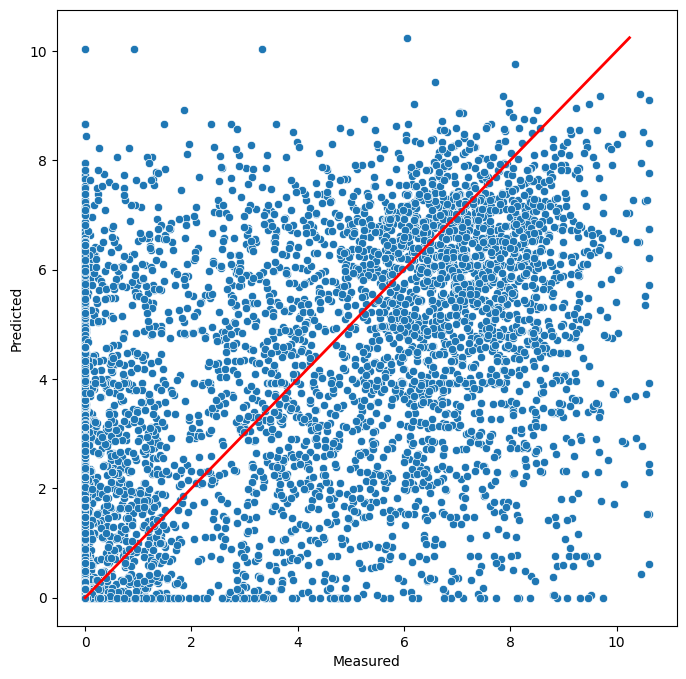

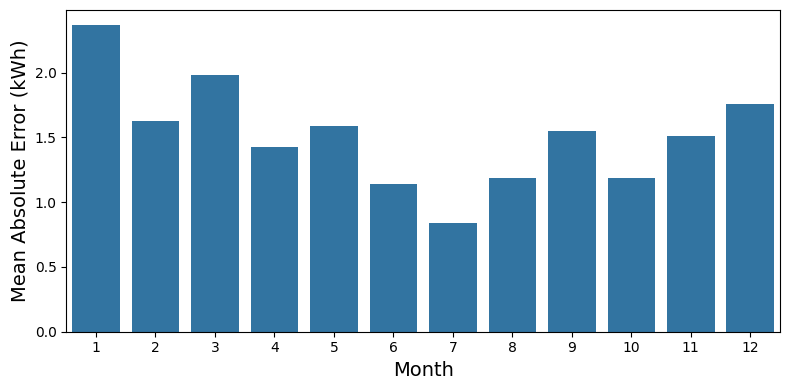

In [17]:
knn_results = monthly_train_and_predict(df, neighbors.KNeighborsRegressor, model.best_params_)

# Artificial Neural Network

In [18]:
import sklearn.neural_network 
max_iterations=1000

In [19]:
# Hyperparameter Tuning
param_grid = [
        {
            'activation' : ['tanh', 'relu'],
            'hidden_layer_sizes': [(i, j) for i in range(10,20) for j in range(10,20)],
            "max_iter": [max_iterations]
        }
       ]

ann = GridSearchCV(sklearn.neural_network.MLPRegressor(), param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
ann.fit(x_train,y_train)

print("Best parameters found:")
print(ann.best_params_)

Best parameters found:
{'activation': 'tanh', 'hidden_layer_sizes': (19, 11), 'max_iter': 1000}


MAE: 0.660 kWh
RMSE: 1.2329 kWh


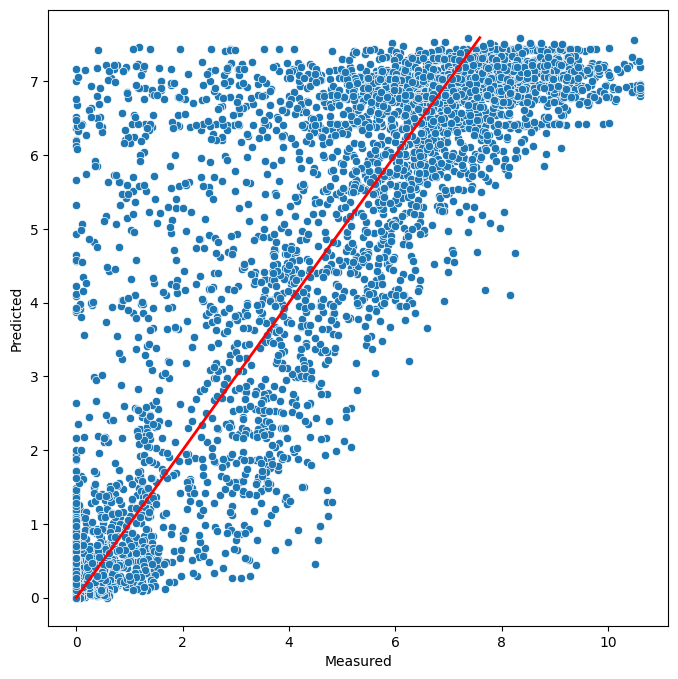

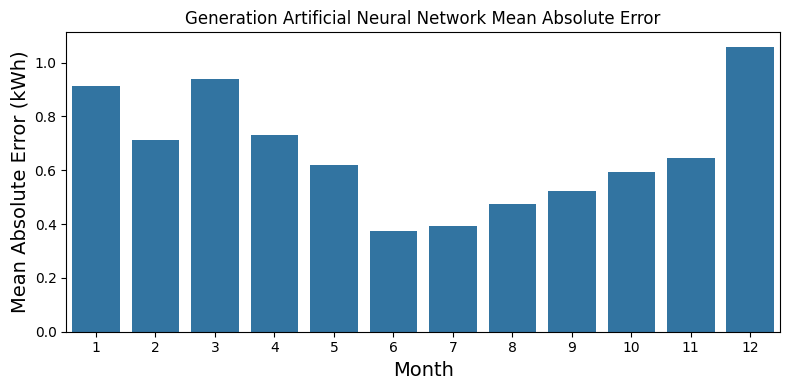

In [20]:
ann_results = monthly_train_and_predict(df, sklearn.neural_network.MLPRegressor, ann.best_params_, title="Generation Artificial Neural Network")

# Support Vector Machine

In [21]:
import sklearn.svm
# Hyperparameter Tuning 
param_grid = [
    {
        'kernel': ['linear'], 
        'gamma': [1e-4, 1e-3, 0.01, "scale"],
        'C': [1, 10, 100, 1000, 10000]
    }
]

svr = GridSearchCV(sklearn.svm.SVR(), param_grid, cv=5, scoring=mae_scorer, n_jobs=-1)
svr.fit(x_train,y_train)

print("Best parameters found:")
print(svr.best_params_)

Best parameters found:
{'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}


MAE: 0.701 kWh
RMSE: 1.2333 kWh


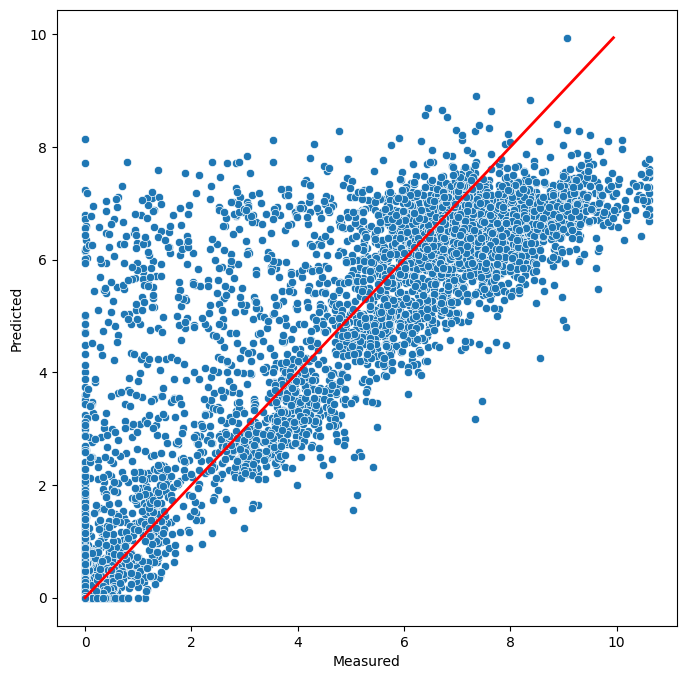

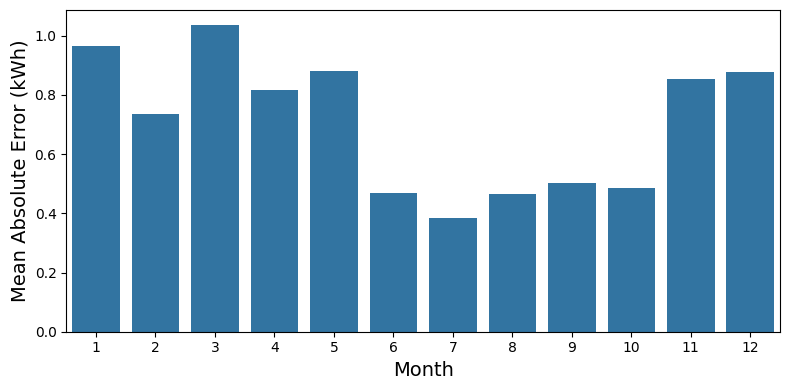

In [22]:
svr_results = monthly_train_and_predict(df, sklearn.svm.SVR, svr.best_params_)

# Results

In [23]:
print(f"LR:  {mean_absolute_error(mlr_results['Measured'], mlr_results['Predicted']):.3f}kWh")
print(f"KNN: {mean_absolute_error(knn_results['Measured'], knn_results['Predicted']):.3f}kWh")
print(f"ANN: {mean_absolute_error(ann_results['Measured'], ann_results['Predicted']):.3f}kWh")
print(f"SVR: {mean_absolute_error(svr_results['Measured'], svr_results['Predicted']):.3f}kWh")

LR:  0.619kWh
KNN: 1.496kWh
ANN: 0.660kWh
SVR: 0.701kWh
